In [47]:
#importing all required python libraries
import shap #shap explanation & interpretation
import lime #lime explanation
import lime.lime_tabular
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import os
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [13]:
#loading & displaying anemia dataset
dataset = pd.read_csv("Dataset/anemia.csv")
dataset

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
0,1,14.9,22.7,29.1,83.7,0
1,0,15.9,25.4,28.3,72.0,0
2,0,9.0,21.5,29.6,71.2,1
3,0,14.9,16.0,31.4,87.5,0
4,1,14.7,22.0,28.2,99.5,0
...,...,...,...,...,...,...
1416,0,10.6,25.4,28.2,82.9,1
1417,1,12.1,28.3,30.4,86.9,1
1418,1,13.1,17.7,28.1,80.7,1
1419,0,14.3,16.2,29.5,95.2,0


In [14]:
#finding sum of missing values
dataset.isnull().sum()

Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64

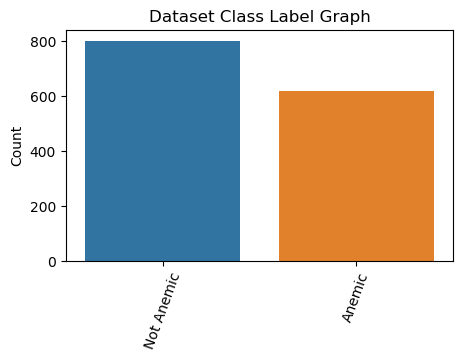

In [15]:
#finding & plotting graph of different Non Anemic & Anemic patients available in dataset
labels = ['Not Anemic', 'Anemic']
names, count = np.unique(dataset['Result'].ravel(), return_counts = True)
plt.figure(figsize = (5, 3)) 
sns.barplot(x=labels, y=count)
plt.title("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.show()

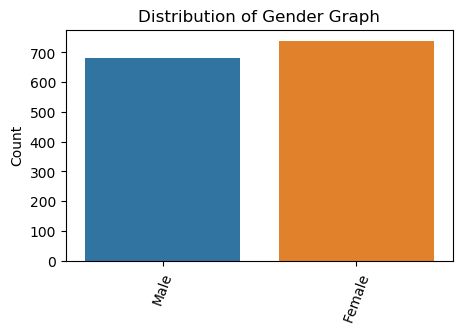

In [16]:
#Distribution of Gender Graph
gender = ['Male', 'Female']
names, count = np.unique(dataset['Gender'].ravel(), return_counts = True)
plt.figure(figsize = (5, 3)) 
sns.barplot(x=gender, y=count)
plt.title("Distribution of Gender Graph")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.show()

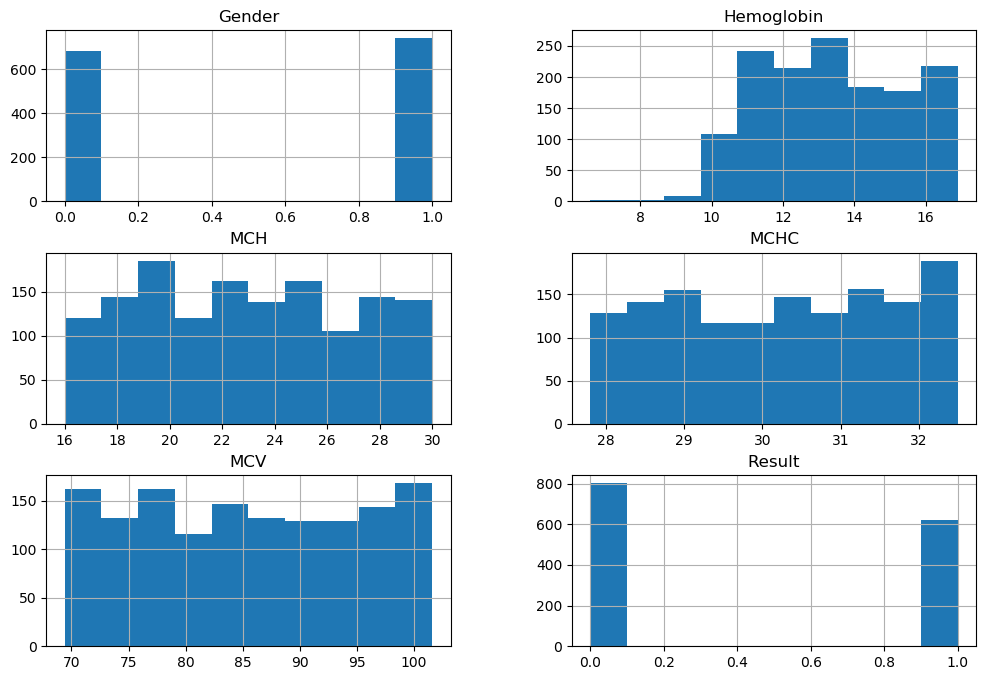

In [17]:
#Variable interactions and distributions by result category
dataset.hist(figsize=(12, 8))
plt.show()

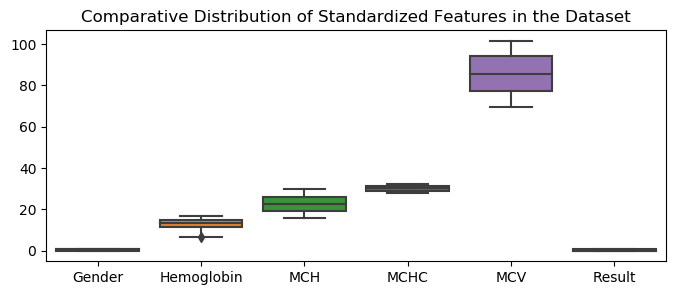

In [18]:
#Comparative distribution of standardized features in the dataset
plt.figure(figsize = (8,3))
sns.boxplot(data = dataset)
plt.title("Comparative Distribution of Standardized Features in the Dataset")
plt.show()

In [19]:
#extracting X & Y features from dataset and then replacing missing values with mean and then normalizing dataset features
dataset.fillna(dataset.mean(), inplace = True)#replace missing values with mean
Y = dataset['Result'].ravel()
Y = Y.astype('int')
dataset.drop(['Result'], axis = 1,inplace=True)
X = dataset.values
scaler = StandardScaler()
X = scaler.fit_transform(X)#normalize features
print("Normalized Training Features = "+str(X))

Normalized Training Features = [[ 0.95930718  0.75348274 -0.05182232 -0.82207061 -0.18932081]
 [-1.04241896  1.26010665  0.62862494 -1.39333406 -1.40385665]
 [-1.04241896 -2.23559834 -0.35424332 -0.46503096 -1.48690183]
 ...
 [ 0.95930718 -0.1584403  -1.31190984 -1.53614992 -0.50074026]
 [-1.04241896  0.44950839 -1.68993609 -0.53643889  1.00445372]
 [-1.04241896 -0.81705139 -0.42984857 -1.32192613  1.30549252]]


In [20]:
#split dataset features into train (80% & test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Split Details")
print("80% dataset features used to train algorithms : "+str(X_train.shape[0]))
print("20% dataset features used to test algorithms : "+str(X_test.shape[0]))
data = np.load("model/data.npy", allow_pickle=True)
X_train, X_test, y_train, y_test = data

Dataset Split Details
80% dataset features used to train algorithms : 1136
20% dataset features used to test algorithms : 285


In [27]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [28]:
#function to evaluate model
def modelEvaluation(algorithm, testY, predict):
    p = round(precision_score(testY, predict,average='macro') * 100, 3)
    r = round(recall_score(testY, predict,average='macro') * 100, 3)
    f = round(f1_score(testY, predict,average='macro') * 100, 3)
    a = round(accuracy_score(testY,predict)*100, 3)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()

Decision Tree Accuracy  : 88.421
Decision Tree Precision : 88.449
Decision Tree Recall    : 89.432
Decision Tree FSCORE    : 88.352


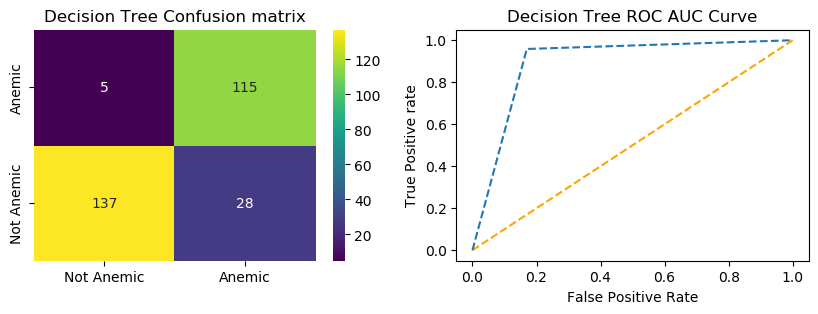

In [29]:
#train decision tree algorithm on 80% training features and then apply trained model on 20% test to calculate prediction accuracy
dt_cls = DecisionTreeClassifier(min_weight_fraction_leaf=0.2)
#train model on training features
dt_cls.fit(X_train, y_train)
#call this function to predict on test data
predict = dt_cls.predict(X_test)
#call this function to calculate accuracy and other metrics
modelEvaluation("Decision Tree", y_test, predict)

KNN Accuracy  : 74.737
KNN Precision : 84.81
KNN Recall    : 70.0
KNN FSCORE    : 69.616


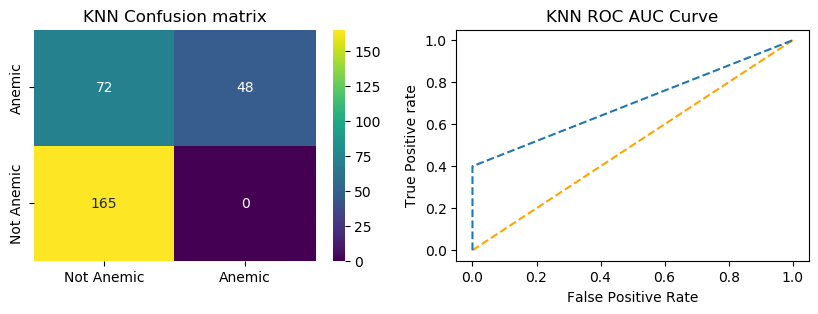

In [30]:
#train KNN algorithm on 80% training features and then apply trained model on 20% test to calculate prediction accuracy
knn_cls = KNeighborsClassifier(n_neighbors=908)
#train model on training features
knn_cls.fit(X_train, y_train)
#call this function to predict on test data
predict = knn_cls.predict(X_test)
#call this function to calculate accuracy and other metrics
modelEvaluation("KNN", y_test, predict)

SVM Accuracy  : 98.596
SVM Precision : 98.387
SVM Recall    : 98.788
SVM FSCORE    : 98.567


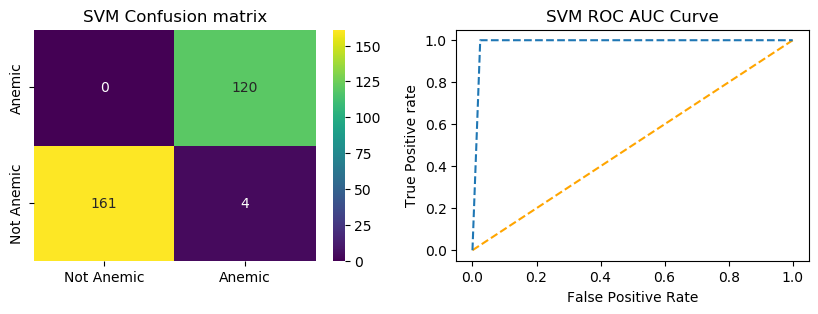

In [31]:
#train SVM algorithm on 80% training features and then apply trained model on 20% test to calculate prediction accuracy
svm_cls = svm.SVC()
#train model on training features
svm_cls.fit(X_train, y_train)
#call this function to predict on test data
predict = svm_cls.predict(X_test)
#call this function to calculate accuracy and other metrics
modelEvaluation("SVM", y_test, predict)

Gradient Boosting Accuracy  : 88.772
Gradient Boosting Precision : 88.745
Gradient Boosting Recall    : 89.735
Gradient Boosting FSCORE    : 88.698


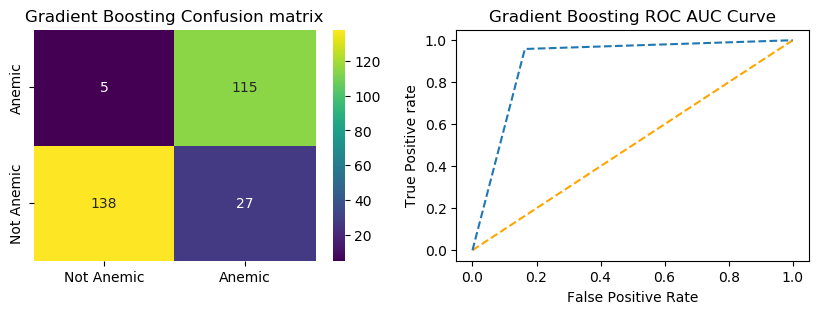

In [32]:
#train Gradient Boosting algorithm on 80% training features and then apply trained model on 20% test to calculate prediction accuracy
gb_cls = GradientBoostingClassifier(min_weight_fraction_leaf=0.49, learning_rate=2.4)
#train model on training features
gb_cls.fit(X_train, y_train)
#call this function to predict on test data
predict = gb_cls.predict(X_test)
#call this function to calculate accuracy and other metrics
modelEvaluation("Gradient Boosting", y_test, predict)

Extension Hybrid Model Accuracy  : 99.649
Extension Hybrid Model Precision : 99.699
Extension Hybrid Model Recall    : 99.583
Extension Hybrid Model FSCORE    : 99.64


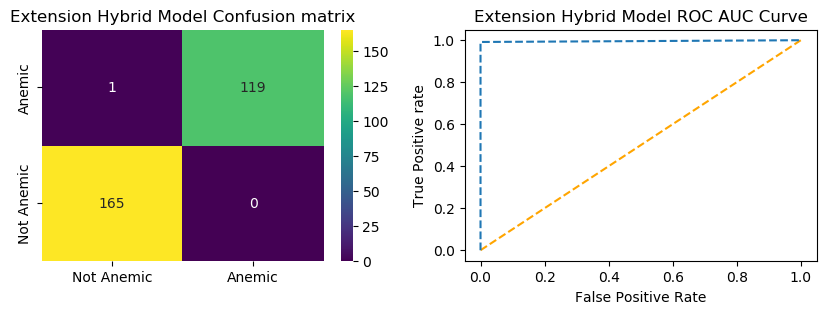

In [37]:
#train Hybrid algorithm by combining multple algorithms such as Random Forest and XGBOOSt and then get trained on 80%
#training features and then apply trained model on 20% test to calculate prediction accuracy
#defining base estimators
xg = XGBClassifier(n_estimators=2)
rf =RandomForestClassifier(n_estimators=2)
estimators = [('xg', xg), ('rf', rf)]
#defining hybrid model by combining Random Forest and XGBOOSt 
hybrid_model = VotingClassifier(estimators = estimators, voting='hard')
#train model on training features
hybrid_model.fit(X_train, y_train)
#call this function to predict on test data
predict = hybrid_model.predict(X_test)
#call this function to predict on test data
modelEvaluation("Extension Hybrid Model", y_test, predict)

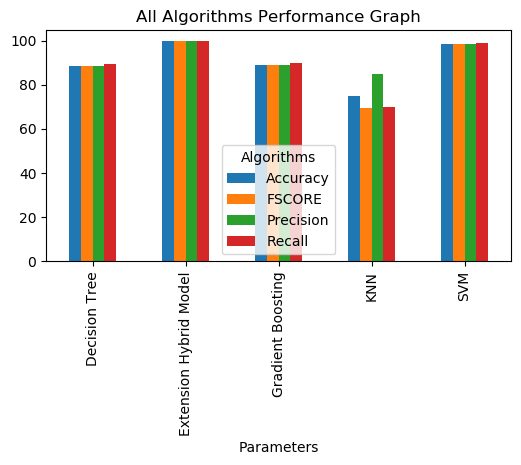

In [39]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['Decision Tree','Accuracy',accuracy[0]],['Decision Tree','Precision',precision[0]],['Decision Tree','Recall',recall[0]],['Decision Tree','FSCORE',fscore[0]],
                   ['KNN','Accuracy',accuracy[1]],['KNN','Precision',precision[1]],['KNN','Recall',recall[1]],['KNN','FSCORE',fscore[1]],
                   ['SVM','Accuracy',accuracy[2]],['SVM','Precision',precision[2]],['SVM','Recall',recall[2]],['SVM','FSCORE',fscore[2]],
                   ['Gradient Boosting','Accuracy',accuracy[3]],['Gradient Boosting','Precision',precision[3]],['Gradient Boosting','Recall',recall[3]],['Gradient Boosting','FSCORE',fscore[3]],
                   ['Extension Hybrid Model','Accuracy',accuracy[4]],['Extension Hybrid Model','Precision',precision[4]],['Extension Hybrid Model','Recall',recall[4]],['Extension Hybrid Model','FSCORE',fscore[4]],
                 
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [40]:
#display all algorithm performnace
algorithms = ['Decsion Tree', 'KNN', 'SVM', 'Gradient Boosting', 'Extension Hybrid Model']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Decsion Tree,88.421,88.449,89.432,88.352
1,KNN,74.737,84.810,70.000,69.616
2,SVM,98.596,98.387,98.788,98.567
3,Gradient Boosting,88.772,88.745,89.735,88.698
4,Extension Hybrid Model,99.649,99.699,99.583,99.640


In [46]:
features = dataset.columns
# setting up lime wih all training data and class labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features, class_names=labels,
                                                   verbose=True, mode='classification')
#giving test data index aalong with random forest predict function to make prediction and then perform explanation
exp = explainer.explain_instance(X_test[15], hybrid_model.estimators_[1].predict_proba, num_features=len(features))
exp.show_in_notebook(show_table=True)

Intercept 0.661713279877653
Prediction_local [0.06267147]
Right: 0.0


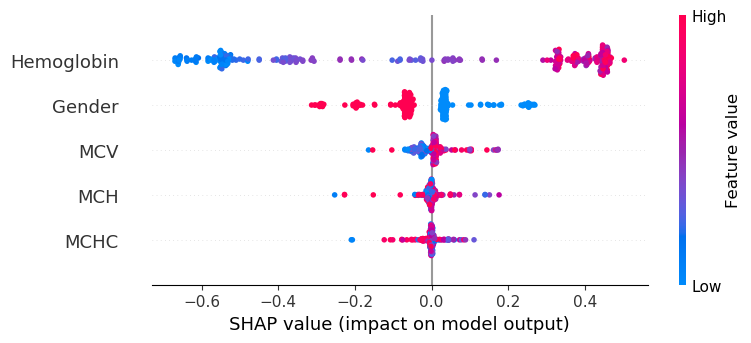

In [48]:
#now explain model prediction using features impact and shap tool
#here we are uisng force plot explanation to explain about features which is contributing most for the model to make
#correct prediction
shap.initjs()
explainer = shap.TreeExplainer(hybrid_model.estimators_[1], X_train)
# Explain the predictions of your model
shap_values = explainer.shap_values(X_test, check_additivity=False)
#summarry plot to explain names of features which is contributing most for the algorithm to make correct prediction
shap.summary_plot(shap_values[0], X_test, feature_names=features)

In [49]:
#loading test data and then applying extension model to predict type of attack
testData = pd.read_csv("Dataset/testData.csv")#load test data
data = testData.values
testData.fillna(dataset.mean(), inplace = True)#replace misisng values with mean    
testData = testData.values    
testData = scaler.transform(testData)#normalize test data
predict = hybrid_model.predict(testData)#apply extension hybrid model to predict anemia
for i in range(len(predict)):
    print("Test Data = "+str(data[i])+" Predicted Booking Status ====> "+labels[predict[i]])
    print()

Test Data = [ 1.  14.5 25.2 31.5 91.7] Predicted Booking Status ====> Not Anemic

Test Data = [  0.   10.4  20.   32.2 101.2] Predicted Booking Status ====> Anemic

Test Data = [ 1.  10.4 17.1 31.4 90.6] Predicted Booking Status ====> Anemic

Test Data = [ 0.  14.8 20.4 28.5 91.1] Predicted Booking Status ====> Not Anemic

Test Data = [  1.   11.9  22.8  32.1 101.2] Predicted Booking Status ====> Anemic

Test Data = [ 1.  11.5 24.1 30.8 74.7] Predicted Booking Status ====> Anemic

Test Data = [ 0.  13.3 16.4 29.1 70. ] Predicted Booking Status ====> Not Anemic

Test Data = [ 1.  13.1 25.6 28.4 77.5] Predicted Booking Status ====> Anemic

Test Data = [  0.   15.5  21.9  31.4 100.5] Predicted Booking Status ====> Not Anemic

Test Data = [ 0.  15.9 28.7 31.  81.6] Predicted Booking Status ====> Not Anemic

Test Data = [ 1.  15.3 25.3 32.2 96.6] Predicted Booking Status ====> Not Anemic

